In [1]:
import gym
import numpy as np
from IPython import display
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class MyWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def show(self):
        plt.figure(figsize=(3, 3))
        state = self.render(mode='rgb_array')
        state = np.array(state)
        state = state.squeeze()
        plt.imshow(state)
        plt.show()

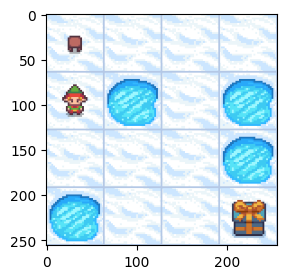

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.hidden_layer = nn.Linear(input_size, 128)
        self.output_layer = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x



def play(env, show=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_size = env.observation_space.n
    output_size = env.action_space.n
    model = QNetwork(input_size, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    learning_rate = 0.8
    discount_factor = 0.95
    num_episodes = 500

    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # 将状态转换为One-Hot编码的向量
            state_one_hot = np.zeros(input_size)
            state_one_hot[state] = 1
            state_tensor = torch.tensor([state_one_hot]).float().to(device)

            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

            if np.random.rand() < 0.1:
                action = env.action_space.sample()

            next_state, reward, done, _ = env.step(action)

            next_state_one_hot = np.zeros(input_size)
            next_state_one_hot[next_state] = 1
            next_state_tensor = torch.tensor([next_state_one_hot]).float().to(device)

            next_q_values = model(next_state_tensor)
            max_next_q_value = torch.max(next_q_values)

            q_target = reward + discount_factor * max_next_q_value
            q_target_tensor = torch.tensor([q_target]).float().to(device)

            optimizer.zero_grad()
            loss = criterion(q_values, q_target_tensor)
            loss.backward()
            optimizer.step()

            total_reward += reward
            state = next_state

            if show:
                display.clear_output(wait=True)
                env.show()

        rewards.append(total_reward)

    return rewards

env = gym.make('FrozenLake-v1')
env = MyWrapper(env)
rewards = play(env, show=True)

# CPU

In [39]:
def play(env, show=False):
    Q = np.zeros((env.observation_space.n, env.action_space.n))#（16,4）16个格子，上下左右4个状态
    learning_rate = 0.8
    discount_factor = 0.95
    num_episodes = 500

    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = np.argmax(Q[state])
            if random.random() < 0.1:
                action = env.action_space.sample()

            next_state, reward, done, _ = env.step(action)

            Q[state, action] += learning_rate * (reward + discount_factor * np.max(Q[next_state]) - Q[state, action])

            total_reward += reward
            state = next_state

            if show:
                display.clear_output(wait=True)
                env.show()

        rewards.append(total_reward)

    return rewards

In [ ]:
env = gym.make('FrozenLake-v1')
env = MyWrapper(env)

rewards = play(env, show=True)

In [ ]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.show()